# 0D model of low-Atwood, single-mode RTI

Lots of imports.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import bisect
from scipy.special import erf
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from globussh import ls
def load_from_archive(names, arch):
    cs = []
    to_remove = []
    for name in names:
        try:
            foo = ls(arch + "/" + "{:s}-results".format(name))
        except:
            to_remove.append(name)
            continue
        cs.append(Chest(path      = "{:s}-results".format(name),
                        open      = partial(glopen,      endpoint=arch),
                        open_many = partial(glopen_many, endpoint=arch)))
    for name in to_remove:
        names.remove(name)
    scs = [CachedSlict(c) for c in cs]

    ps = []
    for name in names:
        with glopen(
                    "{:s}.json".format(name), mode='r',
                    endpoint = arch,
                    ) as f:
            ps.append(json.load(f))
    if len(names) == 1:
        return cs[0], scs[0], ps[0]
    return cs, scs, ps

We're going to compare/train on model on DNS data.  Here, we list which data sets to use and where they live.

In [3]:
config = Foo()
orders = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32]
elms = [4, 8, 12, 16, 24, 32, 48, 64, 96, 128]
#elms = [4, 8, 12, 16, 20, 24, 28, 32]
config.names = []
for order in orders:
    for elm in elms:
        if order * elm >= 64 and order * elm <= 256:
            config.names.append("cnv_o{:d}_e{:d}/cnv_o{:d}_e{:d}".format(order, elm, order, elm))
#config.names.remove("cnv_o4_e24/cnv_o4_e24")
#config.names.remove("cnv_o6_e24/cnv_o6_e24")
#config.names.remove("cnv_o12_e12/cnv_o12_e12")
#config.names     = [
#    "Conv/cnv_o8_e32/cnv_o8_e32",
#    "Conv/cnv_o4_e64/cnv_o4_e64",
#    "Conv/cnv_o16_e8/cnv_o16_e8",
#    "Conv/cnv_o16_e4/cnv_o16_e4",
#    "Conv/cnv_o8_e16/cnv_o8_e16",
#    "Conv/cnv_o8_e8/cnv_o8_e8",
#    "Conv/cnv_o8_e4/cnv_o8_e4", 
#    "Conv/cnv_o6_e4/cnv_o6_e4",
#    "Conv/cnv_o4_e32/cnv_o4_e32",
#    "Conv/cnv_o4_e16/cnv_o4_e16",
#    "Conv/cnv_o4_e8/cnv_o4_e8",    
#    "Conv/cnv_o4_e4/cnv_o4_e4",    
#    ]
config.ref = ["cnv_o16_e32/cnv_o16_e32",]
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
config.arch_end = "alcf#dtn_mira/projects/HighAspectRTI/experiments/ConvergeRTI"

This opens the data.  Could be rolled into a utility routine.

In [4]:
cs, scs, ps = load_from_archive(config.names, config.arch_end);
rc, rsc, rp = load_from_archive(config.ref, config.arch_end);

The data is remote, so we pre-fetch it for efficiency.

In [5]:
#from interfaces.abstract import AbstractSlice
height = 'H_exp'
#mix = 't_abs_proj_z'
mix = 'Xi'
for c,sc in zip(cs, scs):
    c.prefetch(
          sc[:,height].full_keys()
        + sc[:,mix].full_keys()
    )
rc.prefetch(
          rsc[:,height].full_keys()
        + rsc[:,mix].full_keys()
           )
T_end = rsc[:,height].keys()[-1]

For each run in the data set, interpolate the heights with a spline, take a derivative, and compute the mixedness from the `t_abs_proj_z` field.

In [6]:
err_d = {}
for sc, p in zip(scs, ps):
    dh = 0.
    da = 0.
    count = 0
    #print(sc[:,height].keys())
    for T in rsc[:,height].keys():
        if T in sc[:,height].keys():
            dh += (sc[T,height] - rsc[T,height])**2
            da += (sc[T,mix] - rsc[T,mix])**2
            count += 1
#        else:
#            print("Missing T={:} in order={:} Courant={}".format(T, p["order"], p["courant"]))
    if count < 33:
        print("{:},{:} not done, only {:} points".format(p['order'], p['shape_mesh'][0], count))
        continue
    err_d[p['order'], p['shape_mesh'][0], 'H'] = np.sqrt(dh/count)
    err_d[p['order'], p['shape_mesh'][0], 'A'] = np.sqrt(da/count)    
    #print("Done 1")    

20,4 not done, only 31 points
32,8 not done, only 29 points


In [7]:
import pickle
with open("err.p", "wb") as f:
    pickle.dump(err_d, f)

In [40]:
import pickle
with open("times_shaheen.p", "rb") as f:
    times_shaheen = CachedSlict(pickle.load(f))
with open("times_mira.p", "rb") as f:
    times_mira = CachedSlict(pickle.load(f))

EOFError: Ran out of input

In [32]:
import pickle
with open("err.p", "rb") as f:
    err_d = pickle.load(f)

In [38]:
def my_scatter(xs, ys, labels):
    plt.scatter(xs, ys)
    for x, y, label in zip(xs, ys, labels):
        plt.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')

def err_vs(time, name):
    err = CachedSlict(err_d)
    plt.figure(figsize=(16,16))
    core_hr = np.log10(np.array([time[k[0],k[1]] for k in time[:,:].keys() if k in err[:,:,'H'].keys()])/3600)
    log_err = np.log10(np.array([err[k[0], k[1], 'H'] for k in err[:,:,'H'].keys() if k in time[:,:].keys()]))
    labels = ["{:d}, {:d}".format(k[0], k[1]) for k in time[:,:].keys() if k in err[:,:,'H'].keys()]
    my_scatter(core_hr, log_err, labels)
    plt.savefig('{}_H.pdf'.format(name))
    plt.figure(figsize=(16,16))
    log_err = np.log10(np.array([err[k[0], k[1], 'A'] for k in err[:,:,'A'].keys() if k in time[:,:].keys()]))
    my_scatter(core_hr, log_err, labels)
    plt.savefig('{}_A.pdf'.format(name))    

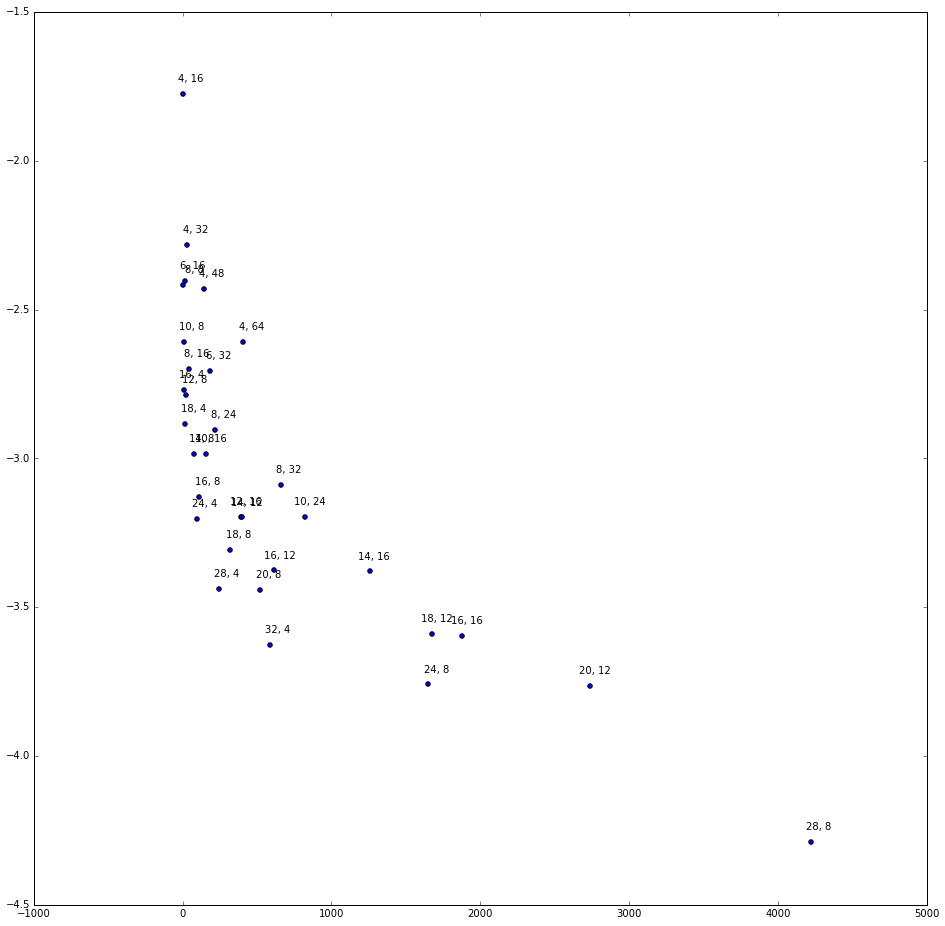

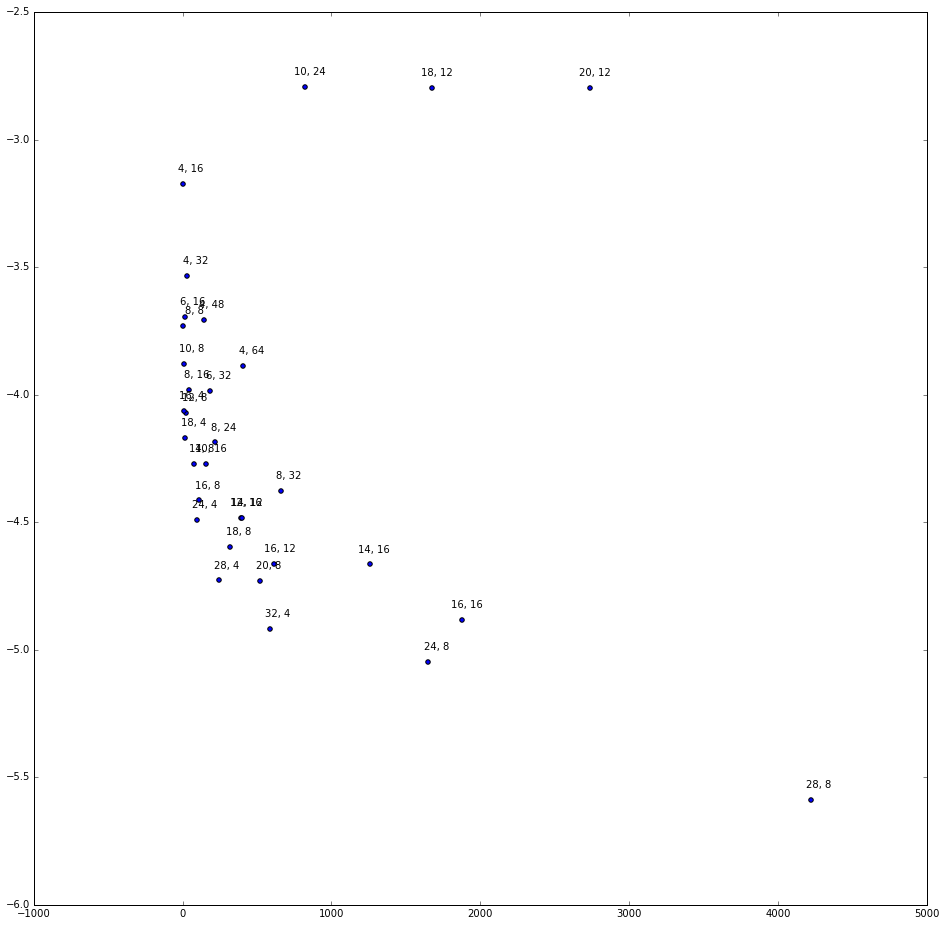

In [34]:
err_vs(times_mira[:,:,'time'], 'mira')

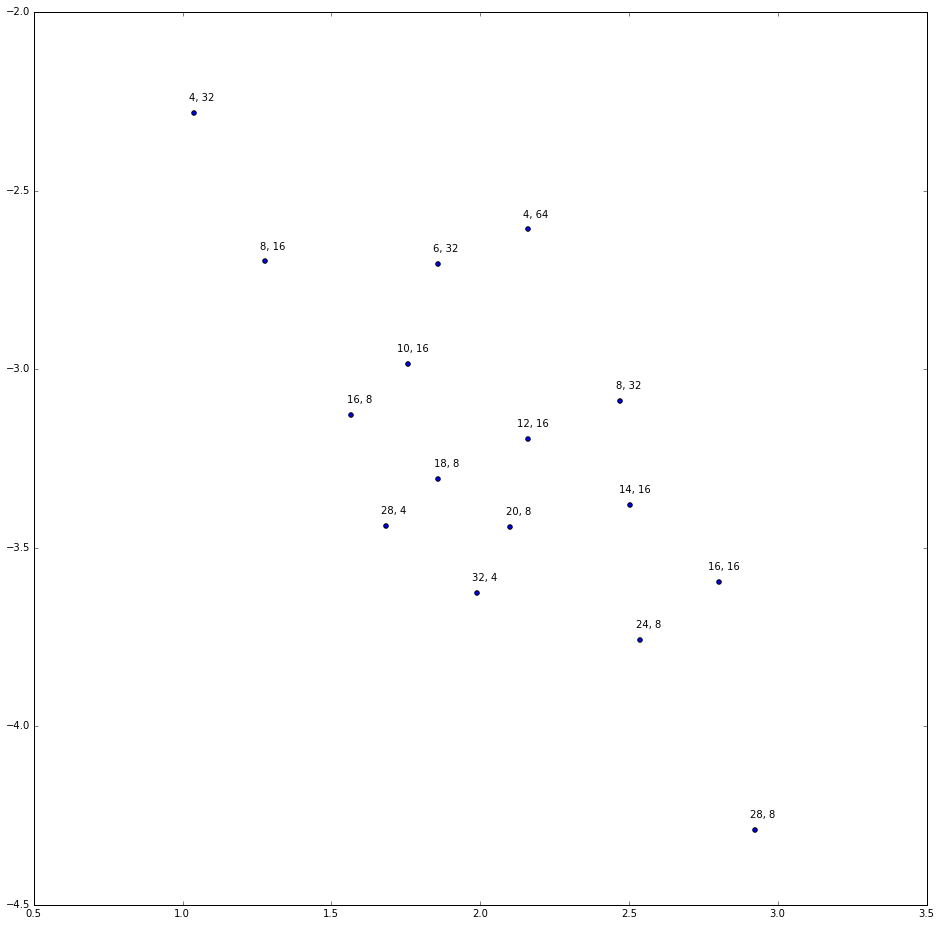

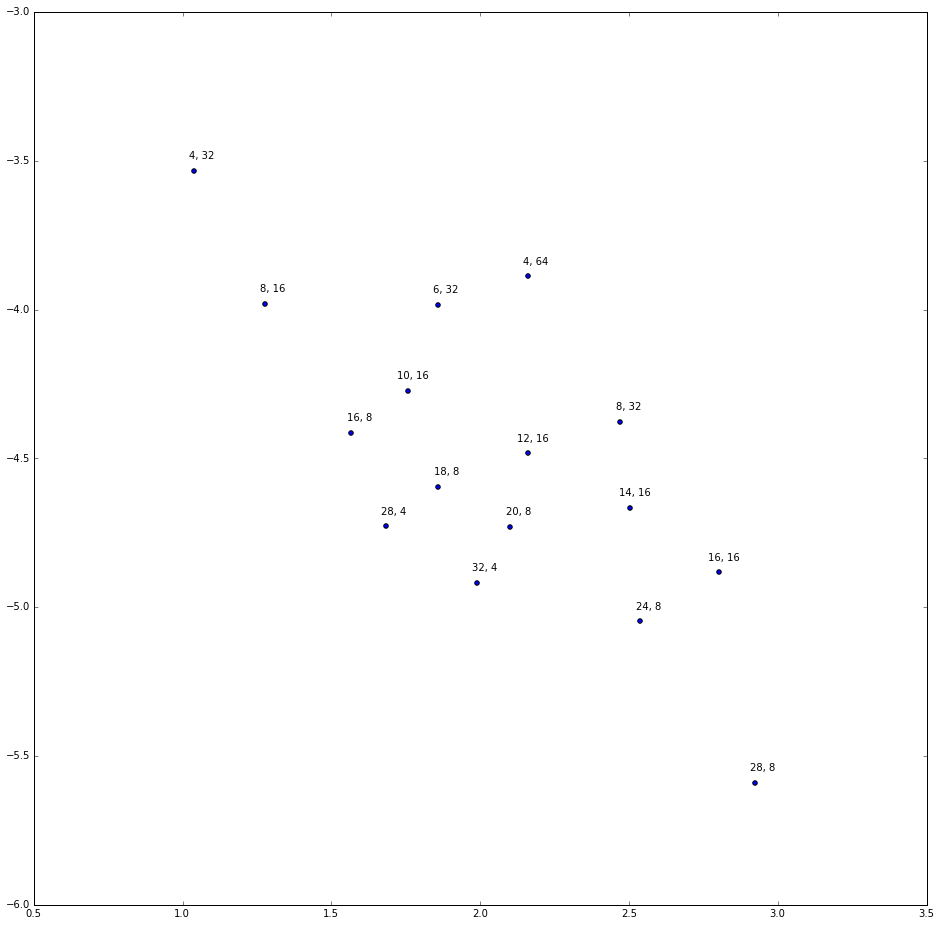

In [39]:
err_vs(times_shaheen[:,:,'time'], 'shaheen')